# Recurrent Neural Network - LSTM - Technical Indicators

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")
import ta
from datetime import timedelta

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Using TensorFlow backend.


### Loading the Data

In [2]:
df = pd.read_csv("SPY.csv")

## Preprocessing Data

### Datetime Conversion

In [3]:
# Datetime conversion
df['Date'] = pd.to_datetime(df.Date)

# Setting the index
df.set_index('Date', inplace=True)

# Dropping any NaNs
df.dropna(inplace=True)

### Technical Indicators

In [4]:
# Adding all the indicators
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Dropping everything else besides 'Close' and the Indicators
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

/anaconda3/lib/python3.7/site-packages/ta/trend.py:543: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/anaconda3/lib/python3.7/site-packages/ta/trend.py:547: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [5]:
# Checking the new df with indicators
print(df.shape)

df.tail()

(1259, 69)


,Close,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-27,287.049988,9.602766e+09,45969900,0.052734,1.688365e+08,25.044953,9.208920,2.310252e+06,4561.065425,8.512108,...,51.904928,94.781855,88.060659,-5.218145,17.850146,275.541443,4.751301,1.441844,1.431549,35.836636
2020-04-28,285.730011,9.509076e+09,-59300100,-0.030747,1.248664e+08,11.142787,5.555074,6.390718e+05,4561.065425,8.260898,...,44.684545,78.317460,87.344555,-21.682540,20.306793,275.626071,2.706685,-0.459842,-0.460903,35.212001
2020-04-29,293.209991,9.539094e+09,59445500,0.020667,2.339162e+08,15.979709,6.364424,2.624505e+06,4561.065425,8.349807,...,51.605502,92.884474,88.661263,-7.115526,22.567293,276.905559,6.366534,2.617849,2.584170,38.751647
2020-04-30,290.480011,9.514410e+09,-63456200,0.060298,1.525683e+08,-6.504168,4.241465,1.964284e+06,4561.065425,7.987828,...,56.008303,81.252689,84.151541,-18.747311,23.495617,277.510981,2.357378,-0.931066,-0.935428,37.459777
2020-05-01,282.790009,9.424102e+09,-188520100,-0.027931,-6.618860e+06,-35.554799,3.172063,-4.455167e+06,4561.065425,8.103046,...,47.679786,47.112915,73.750026,-52.887085,23.726262,277.579561,1.810915,-2.647343,-2.683016,33.820746


In [6]:
# Only using the last 1000 days of data to get a more accurate representation of the current climate
df = df.tail(1000)

### Scaling

In [7]:
# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

close_scaler.fit(df[['Close']])

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [8]:
# Normalizing/Scaling the Data
scaler = RobustScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

df.tail(10)

,Close,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-20,0.301717,0.703077,-0.097597,0.020887,4.246393,-1.085101,7.190792,2.523279,1.901140,4.254813,...,-0.024662,0.212624,0.291212,0.212624,2.151083,0.146169,5.171074,-2.451698,-2.475376,0.301717
2020-04-21,0.122697,0.679715,-0.184741,0.016249,0.906682,-10.350689,4.513933,-6.823563,1.901140,4.233225,...,-0.393401,-0.207080,0.154458,-0.207080,2.129633,0.145297,2.881552,-4.173474,-4.241268,0.122697
2020-04-22,0.249581,0.681569,-0.120255,-0.211177,2.180444,4.023301,8.963496,-2.222827,1.988861,4.126294,...,-0.154273,0.083892,0.025250,0.083892,2.244571,0.149277,4.426382,2.926631,2.896765,0.249581
2020-04-23,0.249162,0.656015,-0.192453,-0.260639,1.843892,2.753898,10.129771,2.366538,1.988861,3.879511,...,-0.721260,0.076755,-0.021363,0.076755,2.464789,0.150657,1.711584,-0.081350,-0.081413,0.249162
2020-04-24,0.330611,0.673141,-0.133731,-0.453540,2.392542,-0.430511,9.844314,1.301711,2.045174,3.657951,...,-0.318395,0.257172,0.137907,0.257172,2.407330,0.153165,2.232642,1.811339,1.800160,0.330611
2020-04-27,0.416038,0.680362,-0.080020,-0.229975,2.828966,5.904110,6.703276,2.656553,2.104238,3.463980,...,-0.402651,0.381749,0.240091,0.381749,2.447829,0.163056,1.474955,1.876147,1.864126,0.416038
2020-04-28,0.388400,0.654166,-0.152605,-0.604168,2.056130,2.586016,3.943019,0.654017,2.104238,3.327451,...,-0.895522,0.030986,0.224390,0.030986,2.844634,0.164805,0.691541,-0.692868,-0.694978,0.388400
2020-04-29,0.545016,0.662559,-0.070729,-0.373708,3.972834,3.740467,4.554434,3.033115,2.104238,3.375772,...,-0.423090,0.341327,0.253260,0.341327,3.209757,0.191245,2.093847,3.464828,3.422780,0.545016
2020-04-30,0.487856,0.655657,-0.155471,-0.196068,2.543029,-1.625864,2.950669,2.241988,2.104238,3.179041,...,-0.122550,0.093519,0.154378,0.093519,3.359702,0.203757,0.557701,-1.329451,-1.336664,0.487856


### Plotting

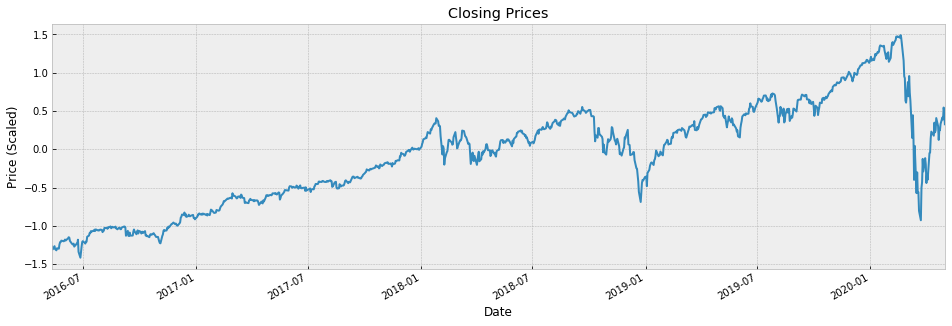

In [9]:
# Plotting the Closing Prices
df['Close'].plot(figsize=(16,5))
plt.title("Closing Prices")
plt.ylabel("Price (Scaled)")
plt.show()

### Functions to prepare the data for LSTM

In [10]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [11]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [12]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

In [13]:
def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(1, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1]+timedelta(days=1), 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions

In [14]:
def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

### Splitting the Data

In [15]:
# How many periods looking back to learn
n_per_in  = 90

# How many periods to predict
n_per_out = 30

# Features 
n_features = df.shape[1]

# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

## Modeling - LSTM (RNN)

### Creating the Neural Network

In [16]:
# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=1, 
            n_nodes=30, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 90, 90)            57600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 30)            14520     
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1830      
Total params: 95,790
Trainable params: 95,790
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### Fitting and Training the RNN

In [18]:
res = model.fit(X, y, epochs=50, batch_size=128, validation_split=0.1)


Train on 792 samples, validate on 89 samples
Epoch 1/50
792/792 [==============================] - 4s 5ms/step - loss: 0.2296 - accuracy: 0.0101 - val_loss: 0.8109 - val_accuracy: 0.0112
Epoch 2/50
792/792 [==============================] - 2s 3ms/step - loss: 0.1131 - accuracy: 0.0265 - val_loss: 0.6311 - val_accuracy: 0.0112
Epoch 3/50
792/792 [==============================] - 3s 4ms/step - loss: 0.0595 - accuracy: 0.0253 - val_loss: 0.5298 - val_accuracy: 0.0112
Epoch 4/50
792/792 [==============================] - 2s 3ms/step - loss: 0.0399 - accuracy: 0.0328 - val_loss: 0.5042 - val_accuracy: 0.0337
Epoch 5/50
792/792 [==============================] - 2s 2ms/step - loss: 0.0266 - accuracy: 0.0467 - val_loss: 0.4863 - val_accuracy: 0.0112
Epoch 6/50
792/792 [==============================] - 2s 2ms/step - loss: 0.0186 - accuracy: 0.0354 - val_loss: 0.4659 - val_accuracy: 0.0112
Epoch 7/50
792/792 [==============================] - 2s 3ms/step - loss: 0.0146 - accuracy: 0.0530 - 

### Plotting the Accuracy and Loss

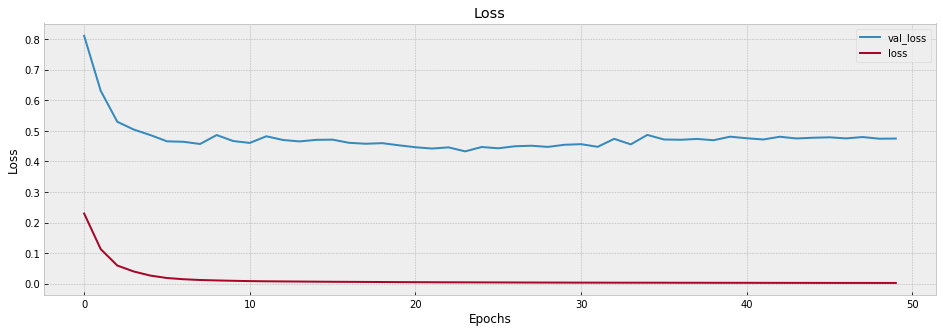

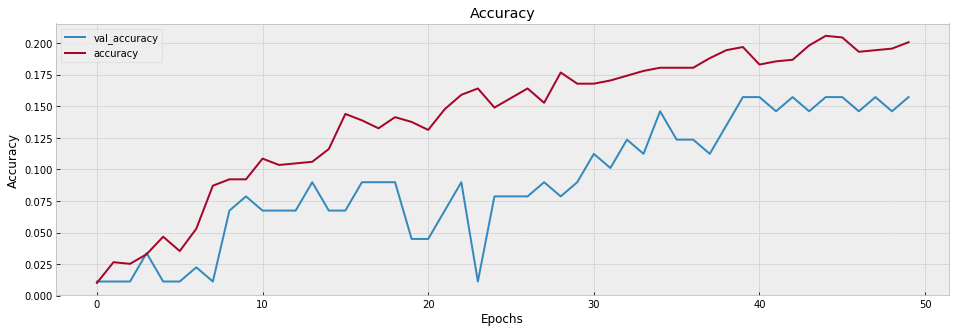

In [19]:
visualize_training_results(res)

## Visualizing the Predictions

### Validating the Model 
Plotting the difference between the Actual closing prices and the Predicted prices

RMSE: 10.406982887153703


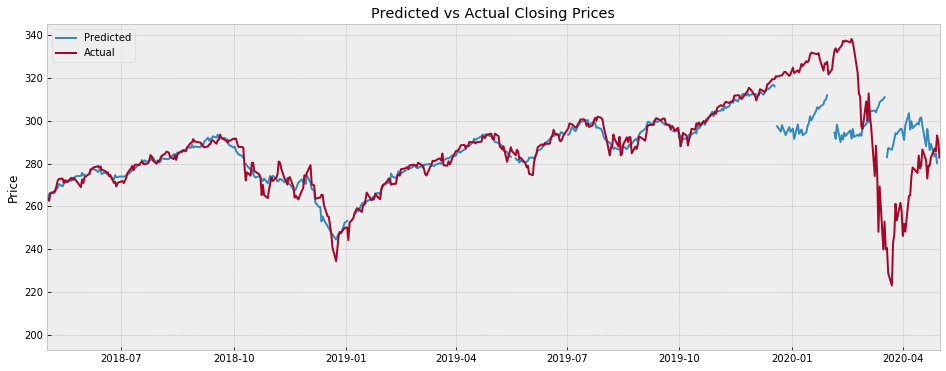

In [20]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.xlim('2018-05', '2020-05')
plt.show()

### Predicting/Forecasting the future prices

                 Close
2020-05-04  283.566589
2020-05-05  282.517822
2020-05-06  289.999084
2020-05-07  292.177979
2020-05-08  287.529266
2020-05-11  289.138947
2020-05-12  295.360321
2020-05-13  293.652222
2020-05-14  295.332031
2020-05-15  289.632721
2020-05-18  297.904327
2020-05-19  291.919769
2020-05-20  289.984192
2020-05-21  292.564728
2020-05-22  289.967773
2020-05-25  291.840240
2020-05-26  286.971375
2020-05-27  290.166382
2020-05-28  287.765503
2020-05-29  286.989136
2020-06-01  288.064087
2020-06-02  288.367157
2020-06-03  284.686920
2020-06-04  286.547516
2020-06-05  287.180542
2020-06-08  289.541962
2020-06-09  288.268829
2020-06-10  289.416229
2020-06-11  291.424774
2020-06-12  289.833801


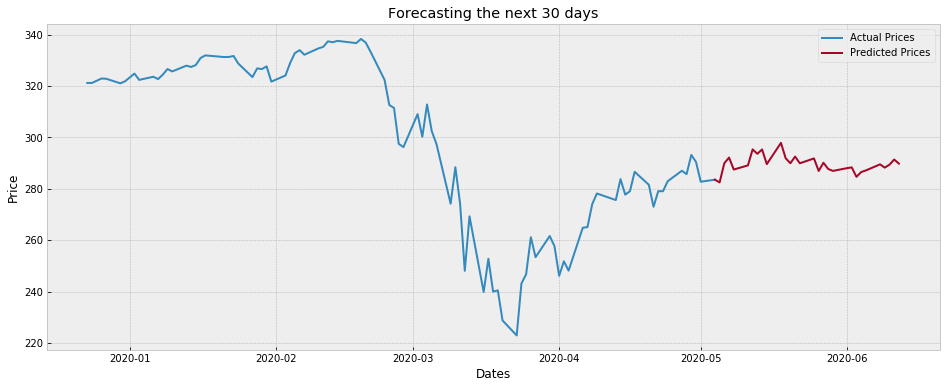

In [21]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
                      index=df.Close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.show()